In [1]:
from dynamical_system.modulation import *
from environment import *
from controller import *
from kernel import *
from visualize_samples import *
import sys

In [ ]:
# class Modulator():
# 	def set_arena(self, arena, target=[1, 1], mod_margin=0.01):
# 		self.target = np.array(target)
# 		self.mod_margin = mod_margin
# 		occ_grid = convolve2d(1 - arena.occ_grid.copy(), np.ones((3, 3)), mode='same') < 1
# 		ccs = find_connected_components(occ_grid)
# 		res = arena.grid_res
# 		bd = arena.grid_bd
# 		grid_xs, grid_ys = np.linspace(-bd, bd, res), np.linspace(-bd, bd, res)
# 		self.gammas = []
# 		for i, cc in enumerate(ccs):
# 			cc_set = set([tuple(c) for c in cc])
# 			bdy = []
# 			for x, y in cc_set:
# 				if ((x - 1, y) not in cc_set) or ((x + 1, y) not in cc_set) or ((x, y - 1) not in cc_set) or ((x, y + 1) not in cc_set):
# 					bdy.append([x, y])
# 			bdy = np.array(bdy)
# 			cc_points = np.stack([grid_xs[cc[:, 1]], grid_ys[cc[:, 0]]], axis=1)
# 			bdy_points = np.stack([grid_xs[bdy[:, 1]], grid_ys[bdy[:, 0]]], axis=1)
# 			gamma = GammaFromPolygon(bdy_points, np.mean(cc_points, axis=0))
# 			self.gammas.append(gamma)

# 	def linear_controller(self, x, max_norm=1):
# 		x_dot = self.target - x
# 		n = np.linalg.norm(x_dot)
# 		if n < max_norm:
# 			return x_dot
# 		else:
# 			return x_dot / n * max_norm

# 	def modulation_HBS(self, pt, orig_ds, margin=0.01):
# 		epsilon = sys.float_info.epsilon
# 		gamma_vals = np.stack([gamma(pt) for gamma in self.gammas])
# 		# calculate each individual modulated control
# 		x_dot_mods = [get_individual_modulation(pt, orig_ds, gamma, self.mod_margin) for gamma in self.gammas]
# 		# calculate weighted average of magnitude
# 		ms = np.log(np.maximum(gamma_vals - 1, 0) + epsilon)
# 		logprod = ms.sum()
# 		bs = np.exp(logprod - ms)
# 		weights = bs / bs.sum()
# 		x_dot_mags = np.array([np.linalg.norm(d) for d in x_dot_mods])
# 		avg_mag = np.dot(weights, x_dot_mags)
# 		x_dot_mods = np.array(x_dot_mods).T
# 		x_dot_mods[:, x_dot_mags > 0] = x_dot_mods[:, x_dot_mags > 0] / x_dot_mags[x_dot_mags > 0]
# 		x_dot = orig_ds / np.linalg.norm(orig_ds)
# 		avg_ds_dir = get_weighted_sum(ref_dir=x_dot, dirs=x_dot_mods, weights=weights)
# 		x_mod_final = avg_mag * avg_ds_dir
# 		return x_mod_final

# 	def modulate(self, x):
# 		orig_ds = self.linear_controller(np.array(x))
# 		d = self.modulation_HBS(x, orig_ds)
# 		return d
    
# def get_individual_modulation(pt, orig_ds, gamma, margin=0.01, tangent_scaling_max=5):
# 	gamma_val = gamma(pt)
# 	if gamma_val > 1e9:  # too far away, no modulation
# 		return orig_ds
# 	elif gamma_val < 1 + margin:  # inside obstacle (including margin). perform repulsion
# 		rel_pt = pt - gamma.center
# 		speed =  (((1 + margin) / gamma_val) ** 5 - (1 + margin)) * 5
# 		if np.linalg.norm(rel_pt) != 0: # nonzero
# 			x_dot_mod = rel_pt / np.linalg.norm(rel_pt) * speed
# 		else:
# 			x_dot_mod = np.array([speed, 0])
# 		return x_dot_mod
# 	else:  # oustide obstacle. perform normal modulation
# 		gamma_grad = gamma.grad(pt)
# 		gamma_grad = gamma_grad / np.linalg.norm(gamma_grad)
# 		ref_pt = gamma.center
# 		E, E_orth = get_decomposition_matrix(pt, gamma_grad, ref_pt)
# 		invE = np.linalg.inv(E)
# 		inv_gamma = 1 / gamma_val
# 		tangent_scaling = max(1, tangent_scaling_max - (1 - inv_gamma))
# 		D = np.diag([1 - inv_gamma, tangent_scaling * (1 + inv_gamma)])
# 		M = np.matmul(np.matmul(E, D), invE)
# 		x_dot_mod = np.matmul(M, orig_ds.reshape(-1, 1)).flatten()
# 		return x_dot_mod

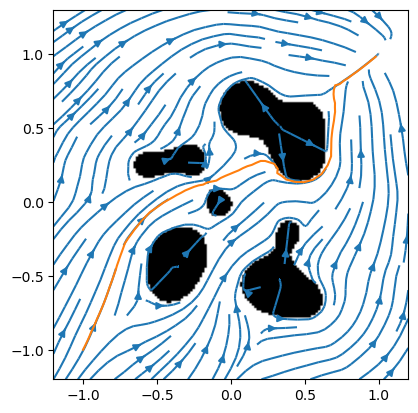

In [2]:
seed = 17 #5 13 17

import random
np.random.seed(seed)
random.seed(seed)

env = RBF2dGymEnv(time_limit=500, oob_termination=False, use_lidar=False)
ds_controller = DSController()
env_kernel = RBF2dEnvKernelNormal()
ds_kernel = TransitionKernel()
# sample 
env_kernel.sample_prior() # sample collision points
# ds_kernel.sample_prior() 
env.reset(obs_override=env_kernel.value)
traj = ds_controller.get_trajectory(env)
plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='binary')
# visualize DS
res = 100
x = np.linspace(-1.2, 1.2, res)
y = np.linspace(-1.2, 1.3, res)
X, Y = np.meshgrid(x, y)
XY=np.array([X.flatten(),Y.flatten()]).T
UV = np.zeros(XY.shape)
for i in range(len(XY)):
    UV[i] = ds_controller.modulator.modulate(XY[i])
plt.streamplot(XY[:, 0].reshape(res, res), XY[:, 1].reshape(res, res), UV[:, 0].reshape(res, res), UV[:, 1].reshape(res, res))
plt.plot(traj[:, 0], traj[:, 1])
# plt.scatter(env.arena.points[:, 0], env.arena.points[:, 1])
plt.show()

In [ ]:
traj_data = []
while len(traj_data) < 100:
    try:
        rand_x = random.uniform(-1.2, 1.2)
        rand_y = random.uniform(-1.2, 1.2)
        env.sim.reset([rand_x, rand_y])
        env.t = 0
        traj = ds_controller.get_trajectory(env)
        traj_data.append(traj)
    except: # the reset position is not in the free space
        pass    

In [51]:
traj.shape

(10, 2)

(770, 739, 4)

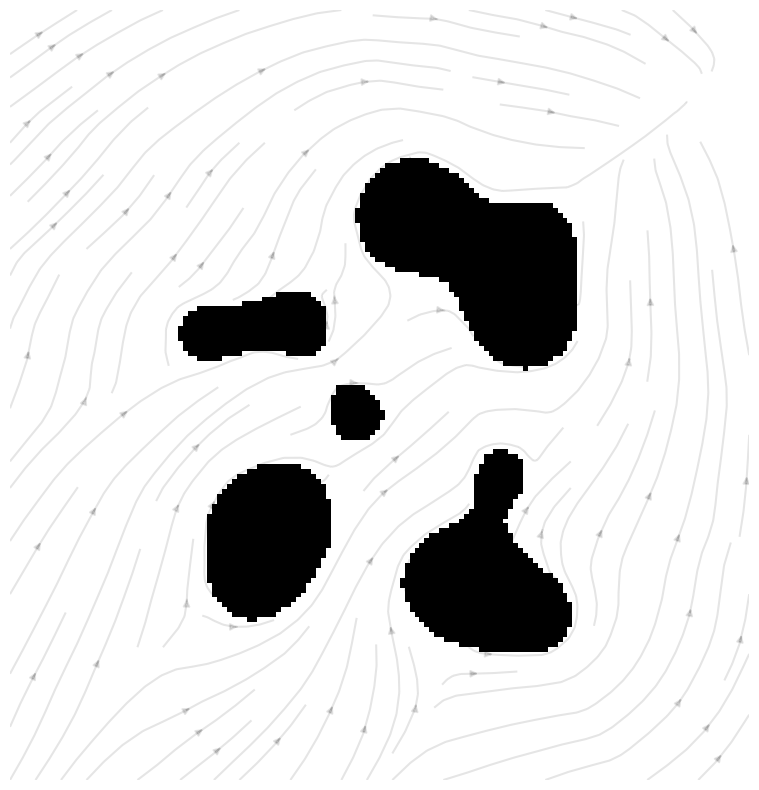

In [37]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='binary')    
plt.streamplot(XY[:, 0].reshape(res, res), XY[:, 1].reshape(res, res), UV[:, 0].reshape(res, res), UV[:, 1].reshape(res, res), color=[0, 0, 0, 0.1])
# for traj in traj_data:
#     plt.scatter(traj[0, 0], traj[0, 1], s=10, alpha=0.5)   
ax.axis('off')

fig.canvas.draw()
plot_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plot_array = plot_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# plot_array = plot_array[:1000, :1000, :]  # crop the image to 300x300
# remove the white padding
fig.savefig('my_plot.png', bbox_inches='tight', pad_inches=0)
# save as npy format
plot_array = plt.imread('my_plot.png')
# np.save('my_plot.npy', plot_array)
plot_array.shape

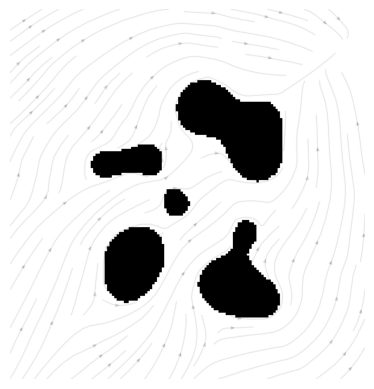

In [38]:
fig, ax = plt.subplots()
ax.axis('off')
plt.imshow(plot_array)
plot_array.shape
np.save('background.npy', plot_array)

In [3]:
sample_res = 32
a = np.linspace(-1.0, 1.0, sample_res)
b = np.linspace(-1.0, 1.0, sample_res)
A, B = np.meshgrid(a, b)
AB = np.array([A.flatten(), B.flatten()]).T

traj_data = []
for start in AB[:-1]: # remove the last entry which coincides with the goal
    try:
        env.sim.reset(start)
        env.t = 0
        traj = ds_controller.get_trajectory(env)
        if len(traj) < 500:
            assert len(traj) < 128, 'traj length longer than 128'
            traj = np.pad(traj, pad_width=((0, 128-len(traj)), (0, 0)), mode='edge')            
            traj_data.append(traj)
    except: # the reset position is not in the free space
        continue

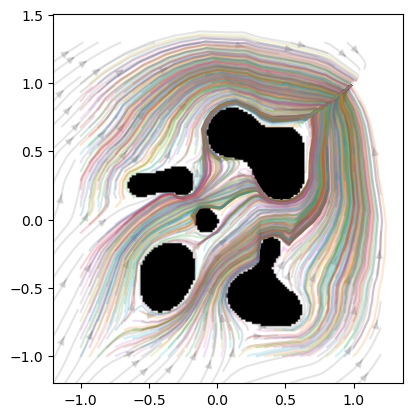

In [8]:
res = 100
plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='binary')    
plt.streamplot(XY[:, 0].reshape(res, res), XY[:, 1].reshape(res, res), UV[:, 0].reshape(res, res), UV[:, 1].reshape(res, res), color=[0, 0, 0, 0.1])
traj_lens = []
traj_longer = []
for traj in traj_data:
    plt.plot(traj[:, 0], traj[0:, 1], alpha=0.2)
    traj_lens.append(len(traj))
    if len(traj) > 100:
        traj_longer.append(traj)

In [6]:
traj_data = np.stack(traj_data)
traj_data.shape

(818, 128, 2)

(array([ 2.,  1.,  2.,  2.,  3.,  4.,  5.,  1.,  4.,  3.,  4.,  4.,  2.,
         6.,  3.,  9.,  8., 10., 10.,  7., 10., 14.,  5., 12.,  4.,  9.,
         9.,  5.,  9.,  5., 10.,  5.,  4.,  4.,  0.,  3.,  1.,  0.,  1.,
         1.]),
 array([ 10. ,  12.6,  15.2,  17.8,  20.4,  23. ,  25.6,  28.2,  30.8,
         33.4,  36. ,  38.6,  41.2,  43.8,  46.4,  49. ,  51.6,  54.2,
         56.8,  59.4,  62. ,  64.6,  67.2,  69.8,  72.4,  75. ,  77.6,
         80.2,  82.8,  85.4,  88. ,  90.6,  93.2,  95.8,  98.4, 101. ,
        103.6, 106.2, 108.8, 111.4, 114. ]),
 <a list of 40 Patch objects>)

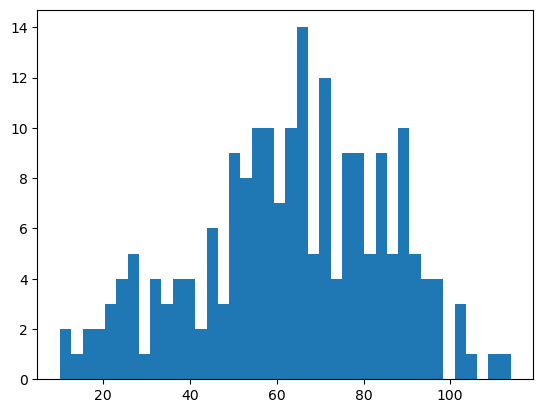

In [48]:
plt.hist(traj_lens, bins=40)

In [11]:
np.save('reach_top_right.npy', traj_data)

In [15]:
ds_field = np.stack((XY, UV))
np.save('ds_field.npy', ds_field)